# Twitter user gender classification


In [1]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Dropout, Activation

import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to /home/oleg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Question 1
In this question we've preprocessed the data in our csv file and analyzed the given data.
We've printed out plots which indicates what are the most commonly used terms and hashtags used by the two opposite genders.

### explanation : 
we tried many ways to clean the text in the right manner to get maximal accuracy in the prediction stage.
one of the ways was to keep letters size (low,high) in the text that starts with '#' or '@' (with the function "lower" that we wrote in the functions cell).
the reason was because we thought man and women write the same words in different size letters when hashtaging them. 
after a few tries the results didn't differ much so we decided to lower all letters for the sake of smaller vocabullary in the bag of words and faster run time for the ANN (my computer crashed like 14 times lol).

### Functions for plot and text preprocessing

In [181]:
def lower(term):
    if term.startswith(('#','@')):
        return term
    else :
        return term.lower()

def clean(words_string):
    '''
    Returns a string after removing stop words and punctuations, lowering all characters and normalizing the words.
    '''
    terms=re.findall(r'('+'|'.join([letters_and_tags_without_numbers_str,emoticons_str])+')',words_string)
    
    stop = set(stopwords.words('english'))
    
    exclude=list(string.punctuation)
    exclude.append('rt')
    exclude.append('via')
    exclude=set(exclude)

    stop.union(exclude)
    
    lemma = WordNetLemmatizer()
    terms=[lower(term) for term in terms]    
    stop_free=[i.lower() for i in terms if i not in stop]
    normalized = " ".join(lemma.lemmatize(term) for term in stop_free)
    return normalized

def uniteLists(list_of_lists_of_words):
    '''
    Doing flat reduce, returning only one list of strings 
    '''
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    '''
    Returns all the terms and their frequencies in the given list.
    '''
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq

def createPlot(x_data,y_data,y_name,x_name,title,i,j,k,color,bartype):
    '''
    Prints a plot for the given inputs:
    x_data - an array for the x axes.
    y_data - an array for the y axes.
    y_name - the label for the y axes.
    x_name - the label for the x axes.
    title - title for the plot.
    i,j,k,color,bartype - some data for the decoration of the graph.
    '''
    axis_font = {'family': 'serif','color':  'black','weight': 'normal','size': 18,}
    title_font = {'family': 'serif','color':  'black','weight': 'normal','size': 22,}
    font_size=16
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_data)
    temp.sort_values(by=(y_name), ascending=True,inplace=True)
    ax = fig.add_subplot(i,j,k) #121
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    ax.set_xlabel(x_name,fontdict=axis_font)
    ax.set_ylabel(y_name,fontdict=axis_font)
    ax.set_title(title,fontdict=title_font)
    temp.plot(kind=bartype,ax=ax,cmap=color)

def findColDiff(df,col_name1,col_name2):
    return df[[col_name1,col_name2]][data_df[col_name1] != data_df[col_name2]]

def printNewCols(start,end):
    for i in range(start,end) :
        print(data_df.iloc[i]['text'])
        print(data_df.iloc[i]['clean_text'])
        print(data_df.iloc[i]['clean_words_list'])
        print(data_df.iloc[i]['hashtags'])
        print(data_df.iloc[i]['user_tag'])
        print()
def printCell(df,rowNum,colName):     
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])

### regular expressions for text filtering
those re help us to clean and filter the tweets.
we focused on few things :
- **urls**- almost all texts had urls that was meaningless for us in the concept of gender prediction.
- **emojies**- Although there weren't many emojies after few tries the predictions resulted better with them.
- **hashtags**- we separated and kept the '#' in the hashtags because after some tests the results was much better with the hashtags than without them. 
- **user_tags**- all words starting with '@'. like in hashtags, here we also kept the sign in the begining of the words because it had more impact on deciding the gender of the writer. for example boys may use the word justin in text but @justinbieber is more likely to be used by girls. 
- **letters_and_tags_str**- cleans the dirty text we don't want and keeps special words like fm.108
- **letters_and_tags_without_numbers_str** - in some stage of our work we decided to reduce the words from **letters_and_tags_str** to the same but without numbers and only words containig numbers in the middle of the word like "NBA2017". that gave us a slight improvment in the results maybe because many numbers in the bag of words caused overfitting.

In [182]:
emoticons_str = r"""(?:[:=;][oO\-]?[Dd\)\]\(\]/\\OpP])"""
html_str=r'<[^>]+>'
user_tags_str=r'(?:@[\w_]+)'
hashtags_str='#[a-zA-Z0-9]+'
url_str= r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
number_str= r'(?:(?:\d+,?)+(?:\.?\d+)?)'
another_str=r"(?:[a-zA-Z0-9#@][a-zA-Z0-9#@'\-_]+[a-zA-Z0-9#@])" # words with - and '
letters_and_tags_str='[a-z\'A-Z0-9#@][a-z\'A-Z0-9#@.-_]*'
letters_and_tags_without_numbers_str='[a-z\'A-Z#@][a-z\'A-Z0-9#@_-]*'

In [191]:
# Reading the data from the file
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = 'latin1') #iso-8859-1

### cleaning the data

- **'text'**- sentence per user cleaned from http links and garbage letters.
- **'hashtag'**- list of #hashtags per user.
- **'user_tag'** - list of @user_tags per user.
- **'clean_text'**- same as 'text' just without #tags and @tags.
- **'clean_words_list'**- same as 'clean_text' just splitted to list of words per user.

In [192]:
def extractCleanedDataFromTweets(df):
    df = df[df['gender'].apply(lambda x : (x=='male' or x=='female') )]

    df['text']=df['text'].apply(lambda x :  re.sub(url_str,"",x))
    df['text']=df['text'].apply(clean)
    df['text']=df['text'].apply(lambda x :  re.sub('[\']+','',x))
    df['text']=df['text'].apply(lambda x :  re.sub('[\s]+',' ',x))

    df['emo']= df['text'].apply(lambda x : re.findall(emoticons_str,x))
    
    df['hashtags']=df['text'].apply(lambda x :  re.findall(hashtags_str,x))
    df['user_tag']=df['text'].apply(lambda x :  re.findall(user_tags_str,x))
    df['clean_text']=df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
    df['clean_words_list']=df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))
    return df

pd.options.mode.chained_assignment = None
data_df=extractCleanedDataFromTweets(data_df)

In [ ]:
df['text']=df['text'].apply(lambda x :  re.sub('[\s]+',' ',x))

In [197]:
def getTfByGender(data_df, gender):
    gender_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(gender_words).most_common()
def getHashtagsByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()
def getEmojiesByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['emo'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()

### male/female_tf contains is list of term:amount of appearnces for all terms per gender. 

In [198]:
male_tf = getTfByGender(data_df, 'male')
female_tf = getTfByGender(data_df, 'female')

### plot of the number of most common terms for male and female

### male/female_hashtag_tf contains all the hashtag:amount of appearnces per gender. 


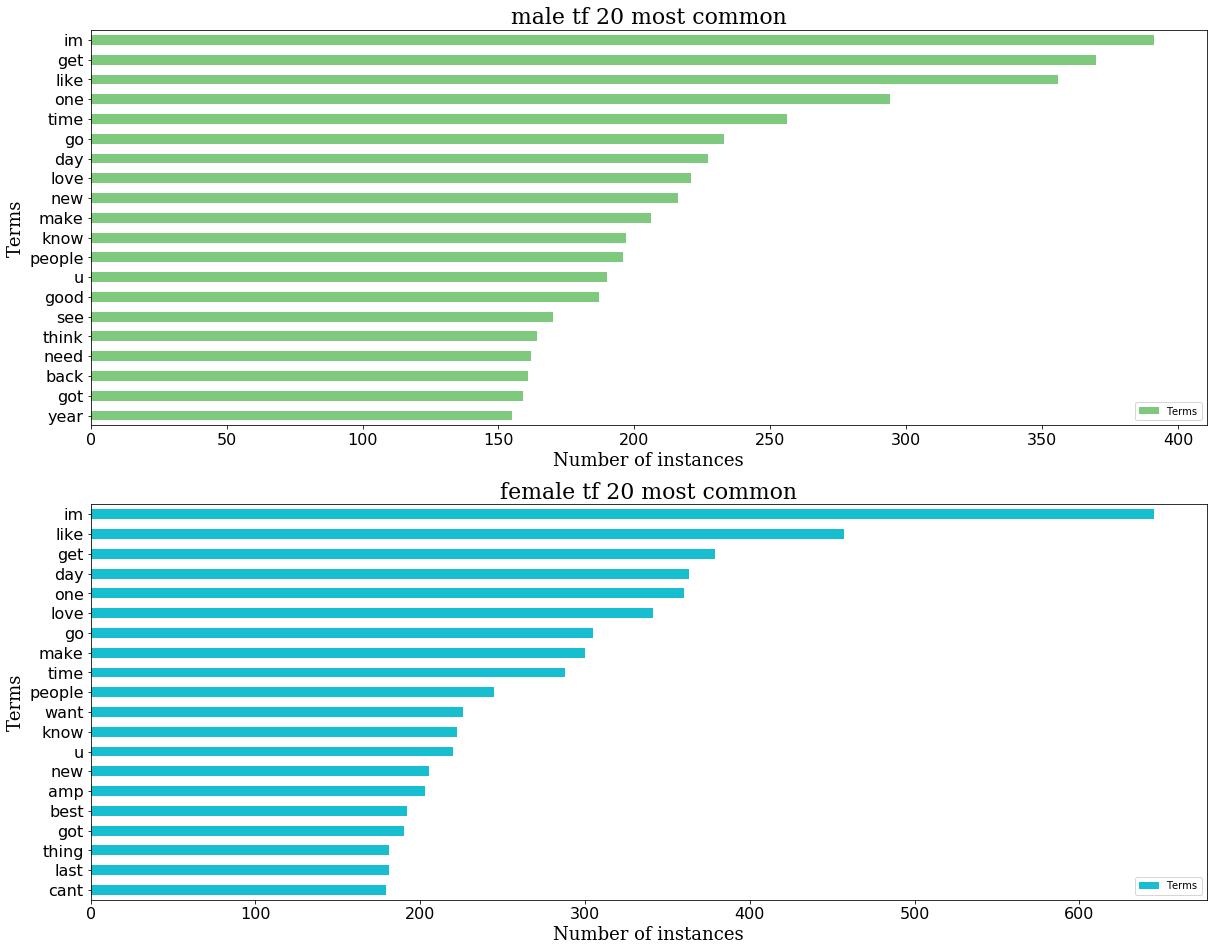

In [200]:
#pd.options.mode.chained_assignment
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

In [201]:
male_hashtag_tf = getHashtagsByGender(data_df, 'male')
female_hashtag_tf = getHashtagsByGender(data_df, 'female')

### plot for num most common #hashtags

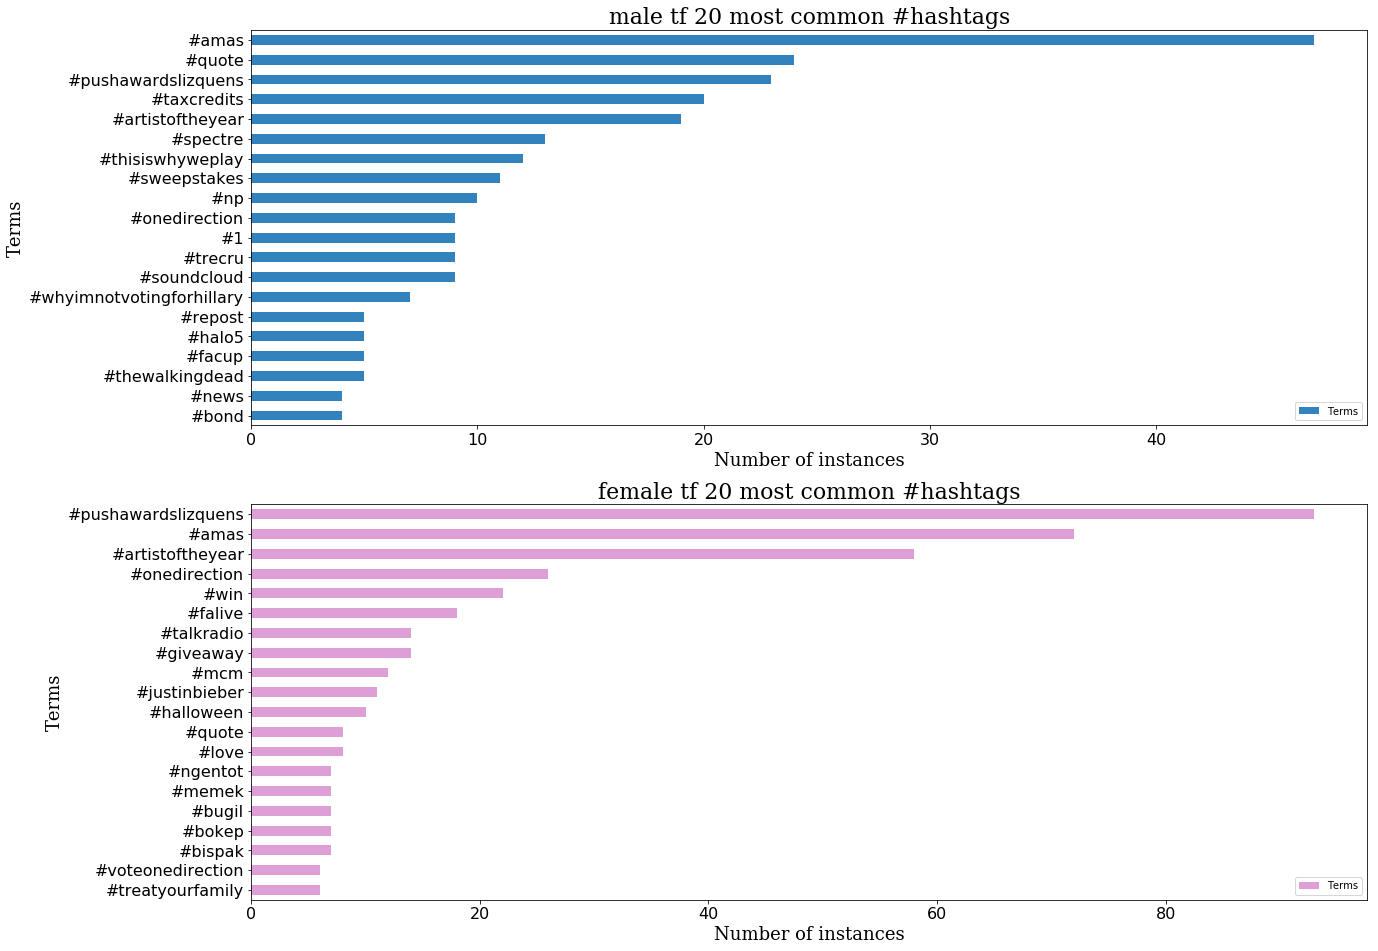

In [202]:
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

### male/female_emo_tf contains emojie: amount of apperances per gender. 

In [203]:
male_emo_tf = getEmojiesByGender(data_df,'male')
female_emo_tf=getEmojiesByGender(data_df,'female')

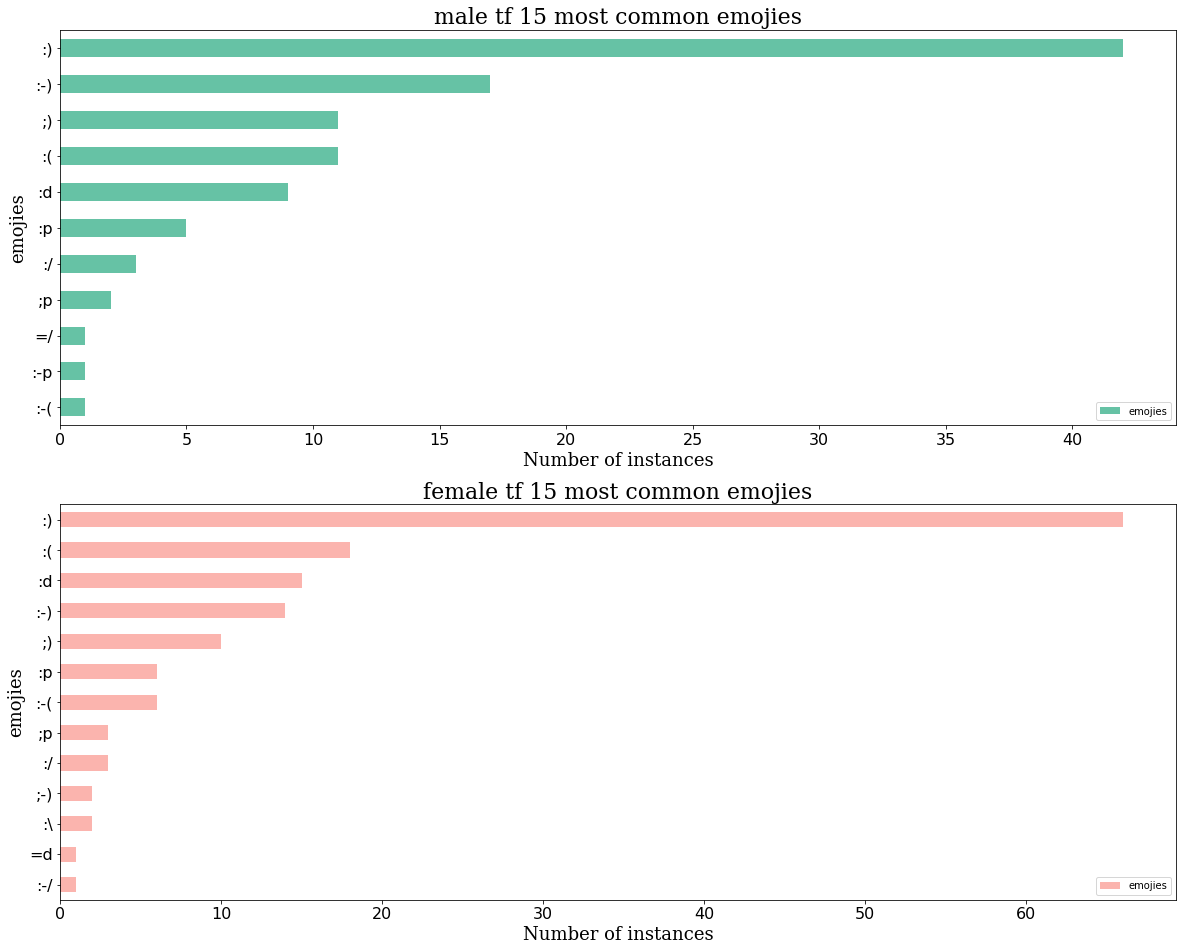

In [204]:
num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','male tf %s most common emojies'%(num),2,1,1,'Set2','barh')
terms,freq=devideToTermsAndFreq(female_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','female tf %s most common emojies'%(num),2,1,2,'Pastel1','barh')

# Question 2
# Train a machine learning model to predict the gender of the tweet author

### functions for question 2

In [205]:
#################################### change gender col in df from string to numeric and vice versa
def changeGenderToNum(word): 
    if word=='male':
        return 1 
    return 0
def changeNumToGender(num):
    if num==0:
        return 'female' 
    return 'male'
####################################

#################################### help us to run multiple classifiction algorithms easier.
def benchmark(clf,x_train,y_train): 
    print('_' * 80)
    print("Training: ")
    print(clf)
    scores = cross_val_score(clf, x_train, y_train, cv=5)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(Y_test, pred)
    print("CV accuracy:   %0.3f" % scores.mean())
    print("Y_test accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [220]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data_df['num_gender']=data_df['gender'].apply(changeGenderToNum)

emojies_and_words_pattern='('+'|'.join([letters_and_tags_without_numbers_str,emoticons_str])+')'
#vectorizer = CountVectorizer(ngram_range=(1,2),lowercase=False,vocabulary=word_for_voc)
vectorizer = CountVectorizer(ngram_range=(1,2),lowercase=False,token_pattern=emojies_and_words_pattern)
#vectorizer = TfidfVectorizer(ngram_range=(1,2),lowercase=False,token_pattern=emojies_and_words_pattern)

test_size=10000

corpus_train=data_df['text'].tolist()[:test_size]
corpus_test=data_df['text'].tolist()[test_size:test_size*2]

vectorizer.fit(corpus_train)

X_train = vectorizer.transform(corpus_train)
Y_train = data_df['num_gender'][:test_size].tolist()

X_test = vectorizer.transform(corpus_test)
Y_test = data_df['num_gender'][test_size:test_size*2].tolist()

In [221]:
len(vectorizer.vocabulary_)
#len(word_for_voc)
vectorizer.vocabulary_.keys()

dict_keys(['robbie', 'e', 'responds', 'critic', 'win', 'eddie', 'edward', '#worldtitleseries', 'robbie e', 'e responds', 'responds critic', 'critic win', 'win eddie', 'eddie edward', 'edward #worldtitleseries', 'felt', 'like', 'friend', 'living', 'story', '#retired', '#ian1', 'felt like', 'like friend', 'friend living', 'living story', 'story #retired', '#retired #ian1', 'absolutely', 'adore', 'louis', 'start', 'song', 'hit', 'hard', 'feel', 'good', 'absolutely adore', 'adore louis', 'louis start', 'start song', 'song hit', 'hit hard', 'hard feel', 'feel good', 'hi', '@jordanspieth', 'looking', 'url', 'use', '@ifttt', 'typically', 'see', 'advanced', 'user', '@pgatour', 'hi @jordanspieth', '@jordanspieth looking', 'looking url', 'url use', 'use @ifttt', '@ifttt typically', 'typically see', 'see advanced', 'advanced user', 'user @pgatour', 'watching', 'neighbour', 'sky', 'catching', 'neighbs', 'xxx', 'watching neighbour', 'neighbour sky', 'sky catching', 'catching neighbs', 'neighbs xxx'

In [224]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
results = []
SVM=SGDClassifier()
NB=MultinomialNB()
KN=KNeighborsClassifier()
RF = RandomForestClassifier(max_depth=2, random_state=0)
for clf, name in (
        (SVM,"SVM"),
        (KN, "kneighbors"),
        (NB,"Naive Bayes"),
        (RF,"Random Forest")
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf,X_train,Y_train))

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.012s
test time:  0.001s
CV accuracy:   0.566
Y_test accuracy:   0.594

kneighbors
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=200, p=2,
           weights='uniform')


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

train time: 0.002s
test time:  0.725s
CV accuracy:   0.510
Y_test accuracy:   0.553

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.010s
test time:  0.001s
CV accuracy:   0.587
Y_test accuracy:   0.611

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
train time: 0.043s
test time:  0.004s
CV accuracy:   0.517
Y_test accuracy:   0.554



In [27]:
X_train=X_train.toarray()
Y_train=np.asarray(Y_train)
X_test=X_test.toarray()
Y_test=np.asarray(Y_test)

In [28]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(123)
# split into input (X) and output (Y) variables
# create model

model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(X_train.shape[0], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# Fit the model
model.fit(X_train, Y_train, epochs=3, batch_size=50)
# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/3


ResourceExhaustedError: OOM when allocating tensor with shape[29152,10000]
	 [[Node: dense_4/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_4/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_4/kernel, dense_4/random_uniform)]]

Caused by op 'dense_4/kernel/Assign', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-3f7b371394d9>", line 10, in <module>
    model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), activation='relu'))
  File "/usr/local/lib/python3.6/site-packages/keras/models.py", line 464, in add
    layer(x)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.6/site-packages/keras/layers/core.py", line 830, in build
    constraint=self.kernel_constraint)
  File "/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/topology.py", line 400, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 385, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 57, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[29152,10000]
	 [[Node: dense_4/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_4/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_4/kernel, dense_4/random_uniform)]]


## Question 3

## Get most tweeted country
We've tried to find which country has the biggest number of tweets in our datasets,
as we can see, combining all the tweets from all the states of USA reveals that it is the most tweeted country.

In [29]:
locations = data_df['tweet_location'][data_df['tweet_location'].apply(lambda x: type(x) == str)]
locations=locations.apply(clean)
locations_tf = Counter(locations).most_common()
locations_tf

[('london', 119),
 ('', 103),
 ('los angeles ca', 57),
 ('uk', 54),
 ('united state', 51),
 ('los angeles', 45),
 ('new york', 40),
 ('london england', 36),
 ('lagos nigeria', 35),
 ('nyc', 35),
 ('chicago il', 33),
 ('texas', 33),
 ('usa', 32),
 ('atlanta ga', 32),
 ('chicago', 31),
 ('california', 31),
 ('boston', 30),
 ('new york ny', 30),
 ('canada', 30),
 ('united kingdom', 29),
 ('washington dc', 28),
 ('austin tx', 26),
 ('houston tx', 25),
 ('england', 25),
 ('toronto', 25),
 ('san francisco ca', 21),
 ('england united kingdom', 21),
 ('manchester', 20),
 ('florida', 19),
 ('new york city', 19),
 ('philadelphia pa', 19),
 ('arry laura', 19),
 ('scotland', 17),
 ('seattle wa', 17),
 ('atlanta', 16),
 ('nigeria', 15),
 ('ohio', 15),
 ('michigan', 15),
 ('earth', 15),
 ('brooklyn ny', 15),
 ('seattle', 15),
 ('glasgow', 14),
 ('charlotte nc', 14),
 ('italy', 14),
 ('denver co', 14),
 ('ireland', 13),
 ('lagos', 13),
 ('houston', 13),
 ('birmingham', 13),
 ('london uk', 13),
 ('sou

In [30]:
# Parameters and functionality initialization for our interaction with twitter api

consumer_key = 'aZgjP0NZeM4iiBaQXJcyOKLJB'
consumer_secret = 'VRLyop5JLP8Kh91CMnE0rpOKUhKEtrrVTCOozHVOd8QEFx69XX'
access_token = '326266960-9RZItG8Q4FUER0BOX4eO8mrvsvrrDWzaWiJqoens'
access_secret = 'v6UHn9puTUv5OgcDwGqf3UxfCZv6XSJZ1gB8UkXOFrnQo'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

In [31]:
JSON_MALE_FILE_NAME='male_tweets.json'
JSON_FEMALE_FILE_NAME='female_tweets.json'
MAX_NUMBER_OF_TWEETS = 219
MALE_FILTER_HASHTAG = '#nba'
FEMALE_FILTER_HASHTAG = '#femalefilmmakerfriday'

class MyListener(StreamListener):
    def __init__(self, jsonFileName):
        self.jsonFileName = jsonFileName
        self.f = open(jsonFileName, 'w')
        self.f.write('[')
        self.tweets_gathered = 0
    
    def on_data(self, data):
    #def on_status(self, status):
        #global tweets_gathered
        if MAX_NUMBER_OF_TWEETS > self.tweets_gathered:
            self.tweets_gathered += 1
            try:
                print(self.tweets_gathered)
                self.f.write(data.rstrip() + ',')
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            self.f.seek
            return False
    def on_error(self, status):
        print("Error" + status)
        return True
    def __del__(self):
        self.f.close()
        #just a fix to the json file
        with open(self.jsonFileName, 'rb+') as self.f:
            self.f.seek(-1, os.SEEK_END)
            self.f.write(b']')    
        print('died')
    def on_exception(self, exception):
        print(exception)

def generateTweets(isMalesGender):
    if isMalesGender:
        jsonFileName = JSON_MALE_FILE_NAME
        filterHashtags = MALE_FILTER_HASHTAG
    else:
        jsonFileName = JSON_FEMALE_FILE_NAME
        filterHashtags = FEMALE_FILTER_HASHTAG
    myList = MyListener(jsonFileName)
    twitter_stream = Stream(auth, myList)
    # I think Asi said she gives up on the location part because students told her it is somewhat problematic with the other fiter.
    # those coordinates are boxed that represents most of america - the country that we've found to have the most tweetings. 
    #twitter_stream.filter(locations=[-124.89,32.7,-93.07,48.99,
    #                                 -110.64,31.98,-84.43,47.01,
    #                                -99.04,26.29,-72.83,41.58,
    #                                -79.0,32.1,-70.6,43.69,
    #                                -75.3,41.06,-66.91,45.06])
    twitter_stream.filter(track=[filterHashtags])
     
# From here we generate the two json files, one for males a
#generateTweets(True)
#generateTweets(False)

In [32]:
new_twitts_male_df = pd.read_json(path_or_buf=JSON_MALE_FILE_NAME)
new_twitts_female_df = pd.read_json(path_or_buf=JSON_FEMALE_FILE_NAME)
new_twitts_male_df['gender'] = 'male'
new_twitts_female_df['gender'] = 'female'

new_twitts_df = new_twitts_male_df.append(new_twitts_female_df, ignore_index = True)

In [35]:
new_twitts_df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,gender
0,NaN,NaN,2018-02-23 21:10:36,NaN,"{'hashtags': [{'text': 'nba', 'indices': [14, ...",NaN,"{'full_text': 'Season prices #nba $15, #nhl $...",0,False,low,NaN,967144685889351682,967144685889351680,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Season prices #nba $15, #nhl $12, #soccer $12...",2018-02-23 21:10:36.452,True,"{'id': 725408779664285696, 'id_str': '72540877...",male
1,NaN,NaN,2018-02-23 21:10:38,NaN,"{'hashtags': [{'text': 'NBA', 'indices': [96, ...",NaN,NaN,0,False,low,NaN,967144695989141511,967144695989141504,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 07:02:48 +0000 2018...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @WorldEliteSyn: Friday is UP !!\n\n*VIP*\n5...,2018-02-23 21:10:38.860,False,"{'id': 967142496982700036, 'id_str': '96714249...",male
2,NaN,NaN,2018-02-23 21:10:48,"[31, 140]","{'hashtags': [{'text': 'BHM', 'indices': [31, ...",NaN,{'full_text': '@TheNBPA @celtics @KyrieIrving ...,0,False,low,NaN,967144735298244608,967144735298244608,TheNBPA,9.670541e+17,9.670541e+17,1.169007e+08,1.169007e+08,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@TheNBPA @celtics @KyrieIrving #BHM #NBA #NBPA...,2018-02-23 21:10:48.232,True,"{'id': 753187516887527424, 'id_str': '75318751...",male
3,NaN,NaN,2018-02-23 21:10:53,NaN,"{'hashtags': [{'text': 'FreePick', 'indices': ...",NaN,NaN,0,False,low,NaN,967144755648978949,967144755648978944,None,NaN,NaN,NaN,NaN,False,pt,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:03:14 +0000 2018...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @EnsaDeportiva: #FreePick #Directas #NBA\n\...,2018-02-23 21:10:53.084,False,"{'id': 2652514767, 'id_str': '2652514767', 'na...",male
4,NaN,NaN,2018-02-23 21:10:57,NaN,"{'hashtags': [{'text': 'NASCAR', 'indices': [1...",NaN,NaN,0,False,low,NaN,967144775341170688,967144775341170688,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:08:05 +0000 2018...,"<a href=""http://twitter.com/download/android"" ...",RT @JerseyKidPicks: Sign-ups all safe and secu...,2018-02-23 21:10:57.779,False,"{'id': 713226793340116992, 'id_str': '71322679...",male
5,NaN,NaN,2018-02-23 21:11:06,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,NaN,967144810485182464,967144810485182464,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:05:04 +0000 2018...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @VegasPropKing: First day back from the all...,2018-02-23 21:11:06.158,False,"{'id': 2883953113, 'id_str': '2883953113', 'na...",male
6,NaN,NaN,2018-02-23 21:11:19,"[0, 79]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,low,NaN,967144866097614848,967144866097614848,None,NaN,NaN,NaN,NaN,True,en,None,0.0,0,{'created_at': 'Fri Feb 23 02:56:02 +0000 2018...,9.668692e+17,9.668692e+17,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",SHE WAS DRUNK ON LIBERALISM! WHAT A UGLY FREAK...,2018-02-23 21:11:19.417,False,"{'id': 1594430870, 'id_str': '1594430870', 'na...",male
7,NaN,NaN,2018-02-23 21:11:20,NaN,"{'hashtags': [{'text': 'Picks', 'indices': [30...",NaN,NaN,0,False,low,NaN,967144871961268224,967144871961268224,None,NaN,NaN,NaN,NaN,False,pt,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:02:27 +0000 2018...,"<a href=""http://twi

In [36]:
# fixes all the places part of the tweet was missing
for i in range(0, new_twitts_df.shape[0]):
    if pd.notnull(new_twitts_df.loc[i,'extended_tweet']):
        new_twitts_df['text'][i] = new_twitts_df['extended_tweet'][i]['full_text']

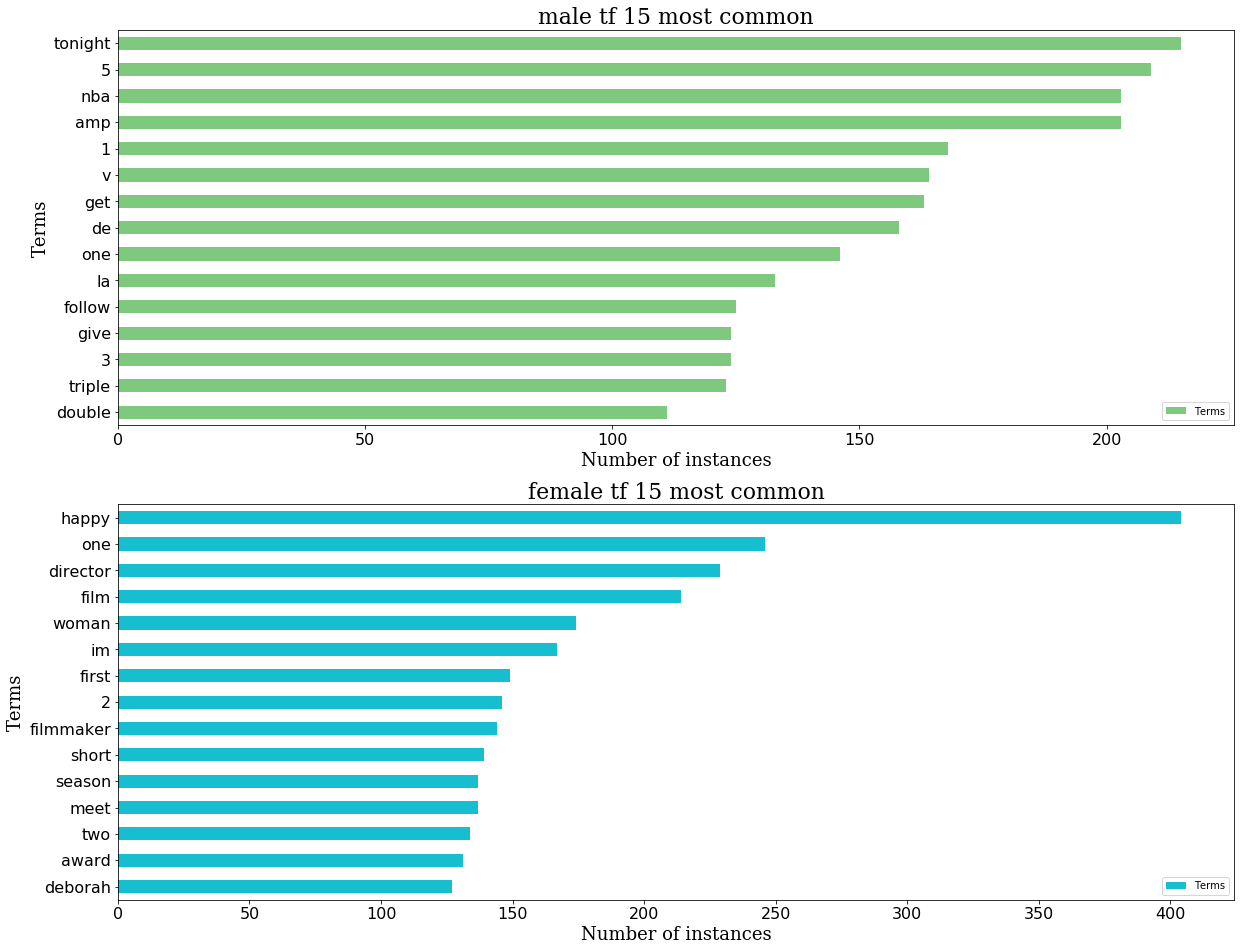

In [37]:
def removePairFromList(lst, el):
    for pair in lst:
        if pair[0] == el:
            lst.remove(pair)

new_twitts_df = extractCleanedDataFromTweets(new_twitts_df)
new_twitts_male_tf = getTfByGender(new_twitts_df, 'male')
new_twitts_female_tf = getTfByGender(new_twitts_df, 'female')
removePairFromList(new_twitts_male_tf, 'rt')
removePairFromList(new_twitts_female_tf, 'rt')

num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(new_twitts_male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(new_twitts_female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### plot for num most common #hashtags

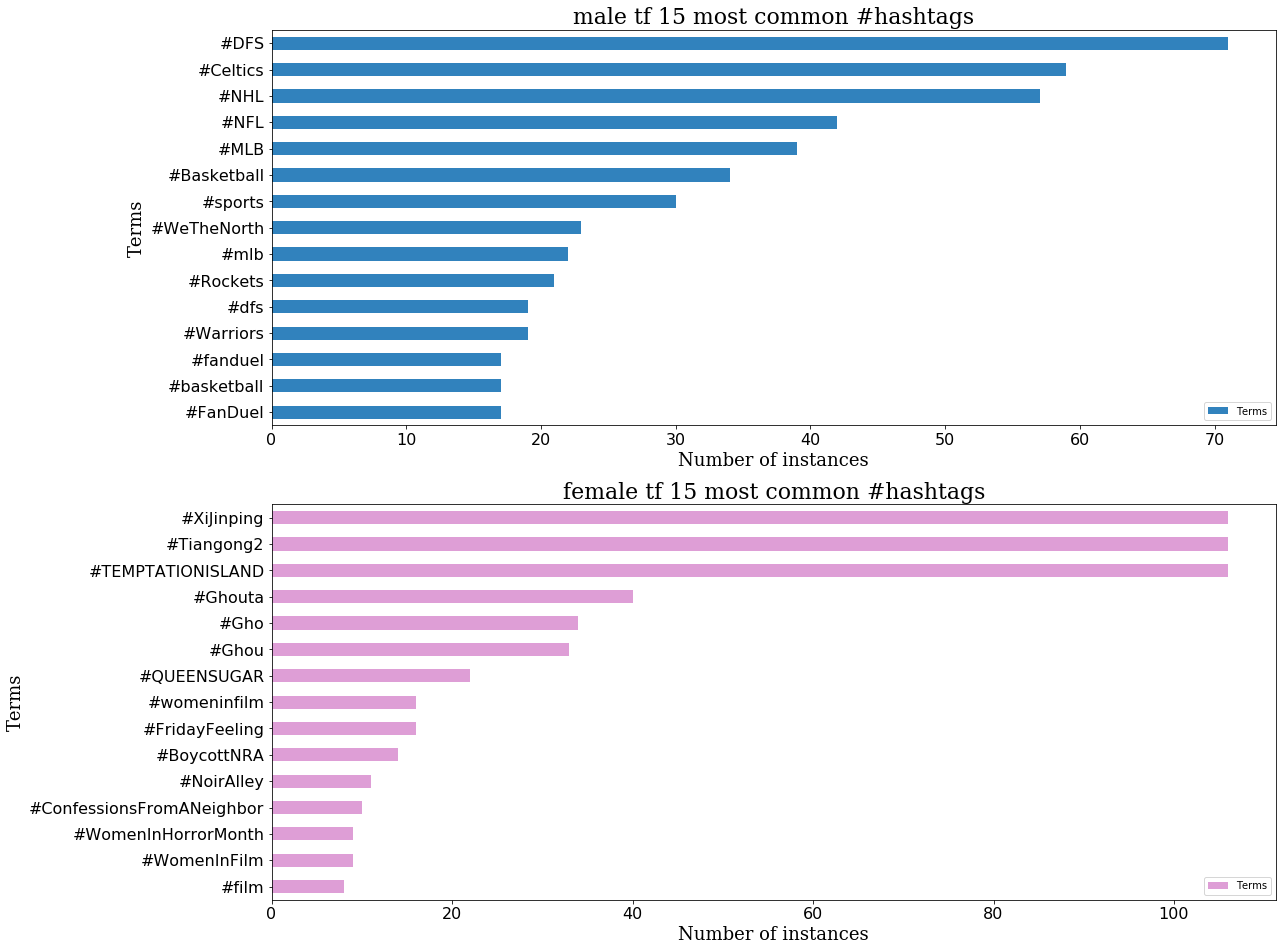

In [39]:
male_hashtag_tf = getHashtagsByGender(new_twitts_df, 'male')
female_hashtag_tf = getHashtagsByGender(new_twitts_df, 'female')
removePairFromList(male_hashtag_tf, '#NBA')
removePairFromList(male_hashtag_tf, '#nba')
removePairFromList(female_hashtag_tf, '#FemaleFilmmakerFriday')
removePairFromList(female_hashtag_tf, '#femalefilmmakerfriday')

num=15
fig = plt.figure(figsize=(18,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')